In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_image(image_path, model, resize = False):

    image_save_prefix = image_path.split('/')[-1].split('.')[0]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if resize:
        image = cv2.resize(image, (128, 128))
        image = image / 255.0

    int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
    input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

    # Predict mask
    predicted_mask =  model.predict(input_image)[0, :, :, 0]  # (128, 128)

    start_time = time.time()*1000
    #scalar region
    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(predicted_mask >= scalar_lower_bound, predicted_mask <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(predicted_mask >= iris_lower_bound, predicted_mask <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    all_points = np.vstack([cnt.reshape(-1, 2) for cnt in scalar_contours])
    leftmost_idx = np.argmin(all_points[:, 0])
    rightmost_idx = np.argmax(all_points[:, 0])
    
    leftmost = tuple(all_points[leftmost_idx])
    rightmost = tuple(all_points[rightmost_idx])

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    # Convert predicted mask to RGB to draw colored circles
    # predicted_mask_rgb = cv2.cvtColor((predicted_mask * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # # Draw circles at leftmost and rightmost points
    # cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
    # cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
    # cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
    # cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
    # cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
    # cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)

    # # Display the mask with circles
    # plt.figure(figsize=(8, 8))
    # plt.imshow(predicted_mask_rgb)
    # plt.title('Predicted Mask with Circles')
    # plt.axis('off')
    # plt.show()

    # # Create the directory if it doesn't exist
    # output_dir = "gaze_vector_prediction"
    # os.makedirs(output_dir, exist_ok=True)

    # # Define the output file path
    # output_file_path = os.path.join(output_dir, image_save_prefix+"_vectors.png")

    # # Save the image
    # cv2.imwrite(output_file_path, cv2.cvtColor(predicted_mask_rgb, cv2.COLOR_RGB2BGR))
    # print(f"Image saved to {output_file_path}")
    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    end_time = time.time()*1000
    print(f"Time taken: {end_time - start_time} ms")
    return iris_center_vector - middle_point_vector

2025-05-12 16:21:17.179508: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 16:21:17.361261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747047077.552696   45551 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747047077.573653   45551 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747047077.716193   45551 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images'
image_files = sorted(os.listdir(image_dir_path))

def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
# model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})
model_2 = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})

# print(calculate_gaze_vector_image('/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000170.png', model , resize= False))
print(calculate_gaze_vector_image('/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000000.png', model_2, resize= True))
# skip = 741

directions = {}

for image_file in image_files:
    image_path = os.path.join(image_dir_path, image_file)
    print(image_path)
    print(f"Processing {image_path}...")
    direction_vector = calculate_gaze_vector_image(image_path, model)
    if(direction_vector is None):
        direction_vector = np.array([0, 0])
    else:
        direction_vector = np.array(direction_vector)
        norm = np.linalg.norm(direction_vector)
        if norm != 0:
            direction_vector = direction_vector / norm
    directions[image_path.split('/')[-1]] = direction_vector
    with open("directions.txt", "a") as file:
        file.write(f"{image_path.split('/')[-1]}: {direction_vector.tolist()}\n")


I0000 00:00:1747047085.652696   45551 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1033 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


KeyboardInterrupt: 

Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(109), np.int32(83))


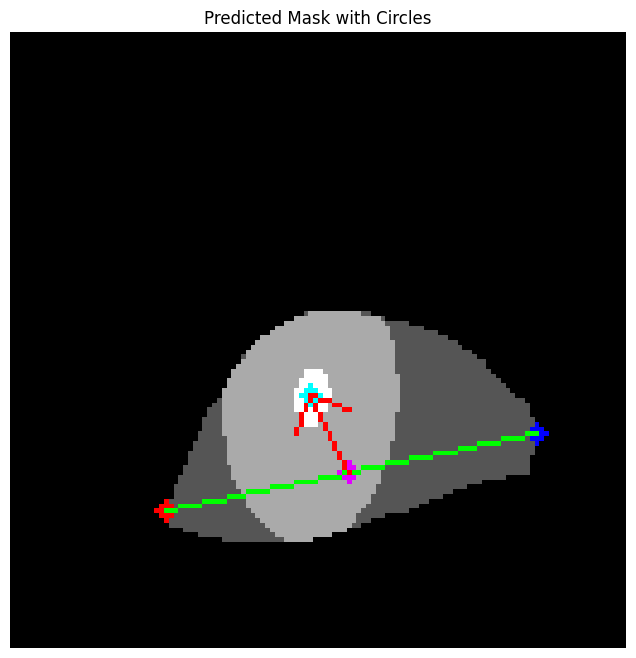

[ -8 -16]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_from_lable_img(label_path):
    label = np.load(label_path)
    label = cv2.resize(label, (128, 128))
    label = label / np.max(label)

    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(label >= scalar_lower_bound, label <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(label >= iris_lower_bound, label <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    # Convert predicted mask to RGB to draw colored circles
    predicted_mask_rgb = cv2.cvtColor((label * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Draw circles at leftmost and rightmost points
    cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
    cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
    cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
    cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)


    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_mask_rgb)
    plt.title('Predicted Mask with Circles')
    plt.axis('off')
    plt.show()

    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    return iris_center_vector - middle_point_vector


image_label_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels'
print(calculate_gaze_vector_from_lable_img('/home/yasas/GazeEstimation/openEDS/openEDS/test/labels/001000.npy'))

image_files = sorted(os.listdir(image_label_path))


# for image_file in image_files:
#     image_path = os.path.join(image_label_path, image_file)
#     print(image_path)
#     print(f"Processing {image_path}...")
#     calculate_gaze_vector_from_lable_img(image_path)